In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import tqdm
from getdata import get_tensor_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Step 1: Load data
file_path = "./data/"
file_name = "BA.csv"
train_x, train_y, test_x, test_y = get_tensor_dataset(file_path, file_name, 1, 1)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([1399]) torch.Size([1399]) torch.Size([2851]) torch.Size([2851])


In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
# to cuda
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()
test_y = test_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

In [5]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 854.150   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 757.368   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 672.919   lengthscale: 0.798   noise: 0.798
Iter 4/50 - Loss: 599.863   lengthscale: 0.853   noise: 0.853
Iter 5/50 - Loss: 536.375   lengthscale: 0.911   noise: 0.908
Iter 6/50 - Loss: 481.195   lengthscale: 0.969   noise: 0.965
Iter 7/50 - Loss: 433.262   lengthscale: 1.029   noise: 1.022
Iter 8/50 - Loss: 391.797   lengthscale: 1.090   noise: 1.079
Iter 9/50 - Loss: 355.675   lengthscale: 1.151   noise: 1.135
Iter 10/50 - Loss: 324.258   lengthscale: 1.212   noise: 1.190
Iter 11/50 - Loss: 296.924   lengthscale: 1.274   noise: 1.244
Iter 12/50 - Loss: 272.955   lengthscale: 1.335   noise: 1.297
Iter 13/50 - Loss: 251.977   lengthscale: 1.396   noise: 1.348
Iter 14/50 - Loss: 233.525   lengthscale: 1.456   noise: 1.397
Iter 15/50 - Loss: 217.244   lengthscale: 1.515   noise: 1.445
Iter 16/50 - Loss: 202.851   lengthscale: 1.573   noise: 1.491
I

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [7]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

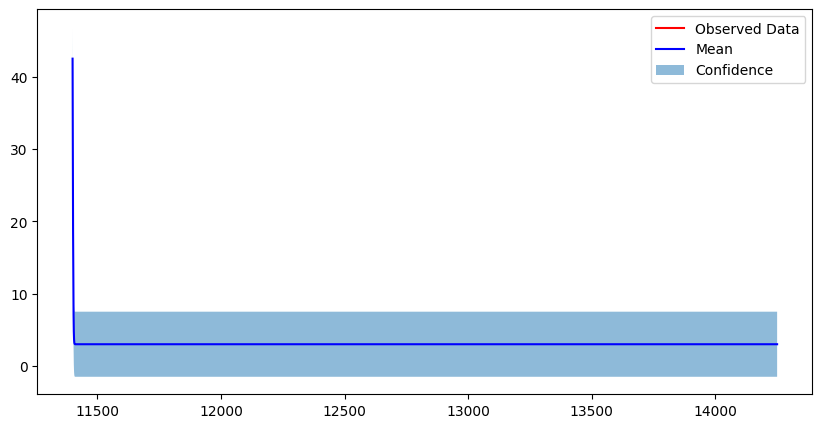

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # for train_x, start from 10000
    plot_x = train_x[:].numpy()
    plot_y = train_y[:].numpy() 

    # Plot training data as black stars
    ax.plot(plot_x, plot_y, 'r')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])